# Preprocessing-Slight

In [64]:
import pandas as pd
import ast

hocs = pd.read_csv("../csv/HoCs.csv")
hocs = hocs.reset_index(drop=True)
hocs

,hocs,plant_name
0,[210 0 0 0 0 0 0 0 74 0 0 ...,acer_campestre
1,[325 0 0 0 0 0 0 0 157 0 0 ...,acer_campestre
2,[496 0 0 0 0 0 0 0 195 0 0 ...,acer_campestre
3,[516 0 0 0 0 0 0 0 193 0 0 ...,acer_campestre
4,[232 0 0 0 0 0 0 0 128 0 0 ...,acer_campestre
...,...,...
900,[222 0 0 0 0 0 0 0 120 0 0 ...,zelkova_serrata
901,[222 0 0 0 0 0 0 0 121 0 0 ...,zelkova_serrata
902,[280 0 0 0 0 0 0 0 119 0 0 ...,zelkova_serrata
903,[230 0 0 0 0 0 0 0 134 0 0 ...,zelkova_serrata


In [78]:
hocs_list = list(hocs['hocs'])
clean_hocs = []
plants = hocs['plant_name']

for _hocs in hocs_list:
    # Remove the square brackets at the beginning and end of the string
    data_string = _hocs.strip("[]")

    # Split the string by ',,,' to get individual elements
    elements = data_string.split(" ")
    elements = [x.replace("\n", "") for x in elements]
    data_list = list(filter(lambda x: x != '', elements))
    data_list = [int(x) for x in data_list]
    clean_hocs.append(data_list)

In [83]:
data = [clean_hocs, plants]

# Nearest Neighbors - Training

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

In [104]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Create a nearest neighbors object with n_neighbors set to 25
nbrs = NearestNeighbors(n_neighbors=15, algorithm='brute', metric='cosine').fit(data[0])
nbrs

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=15)

In [105]:
input_hist = np.array(data[0][6])
print(len(input_hist))

25


In [106]:
# Use the HoCS feature vector extracted from the input image as the query
query = input_hist.reshape(1, -1)
query

array([[409,   0,   0,   0,   0,   0,   0,   0, 128,   0,   0,   0,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0, 127]])

In [107]:
# Perform the nearest neighbors search
distances, indices = nbrs.kneighbors(query)

In [108]:
import matplotlib.pyplot as plt
from PIL import Image

# Show the top n matches to the user
for i in range(len(indices[0])):
    index = indices[0][i]
    distance = distances[0][i]
    species = data[1][index]

    print(f"Match {i} Species: {data[1][index]} Distance: {distance}")

Match 0 Species: acer_campestre Distance: 0.0
Match 1 Species: acer_campestre Distance: 4.357972403257193e-05
Match 2 Species: acer_pensylvanicum Distance: 6.261407713259448e-05
Match 3 Species: styrax_japonica Distance: 0.00012047695315253737
Match 4 Species: acer_ginnala Distance: 0.00012195257363945
Match 5 Species: styrax_japonica Distance: 0.0001453461861978811
Match 6 Species: acer_campestre Distance: 0.0001798663199383821
Match 7 Species: acer_campestre Distance: 0.00018967753652621155
Match 8 Species: acer_campestre Distance: 0.0003472626020611935
Match 9 Species: acer_ginnala Distance: 0.000384826148973727
Match 10 Species: acer_campestre Distance: 0.00041545821866517674
Match 11 Species: acer_ginnala Distance: 0.0005305786130445078
Match 12 Species: acer_ginnala Distance: 0.0007311282631128346
Match 13 Species: acer_pensylvanicum Distance: 0.0009465076501110614
Match 14 Species: quercus_nigra Distance: 0.0012187060176337416


In [110]:
# Initialize the nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=15, algorithm='brute', metric='cosine')

species_match_ranks = []
for i in range(len(data[0])):
     # Use the i-th field image as query, and remove it from the field features array
    query = data[0][i]
    field_features_minus_query = np.delete(data[0], i, axis=0)

    # Train the nearest neighbors model on the remaining field images
    nn_model.fit(field_features_minus_query)

    query = np.array(query)
    # Find the nearest neighbors and their labels for the query image
    distances, indices = nn_model.kneighbors(query.reshape(1, -1))

    # Evaluate the rank of the correct species match for the query image
    correct_species = data[1][i]
    species_neighbors = data[1][indices.flatten()]
    species_neighbors_arr = np.array(species_neighbors)

    if correct_species in species_neighbors_arr:
        correct_species_rank = np.where(species_neighbors_arr == correct_species)[0][0] + 1  # add 1 to convert to rank
        
    species_match_ranks.append(correct_species_rank)


In [111]:
# Calculate the recognition rate for each rank
recognition_rates = []
for rank in range(1, 15 + 1):
    count_correct_species = sum([1 for r in species_match_ranks if r is not None and r <= rank])
    recognition_rate = count_correct_species / len([r for r in species_match_ranks if r is not None])
    recognition_rates.append(recognition_rate)

# Print the recognition rate for each rank
for rank, rate in enumerate(recognition_rates, start=1):
    print("Recognition Rate (Rank {}): {:.2f}%".format(rank, rate * 100))

Recognition Rate (Rank 1): 22.54%
Recognition Rate (Rank 2): 34.36%
Recognition Rate (Rank 3): 45.08%
Recognition Rate (Rank 4): 52.27%
Recognition Rate (Rank 5): 57.57%
Recognition Rate (Rank 6): 64.31%
Recognition Rate (Rank 7): 68.84%
Recognition Rate (Rank 8): 72.15%
Recognition Rate (Rank 9): 77.79%
Recognition Rate (Rank 10): 82.21%
Recognition Rate (Rank 11): 86.85%
Recognition Rate (Rank 12): 90.06%
Recognition Rate (Rank 13): 95.14%
Recognition Rate (Rank 14): 97.68%
Recognition Rate (Rank 15): 100.00%


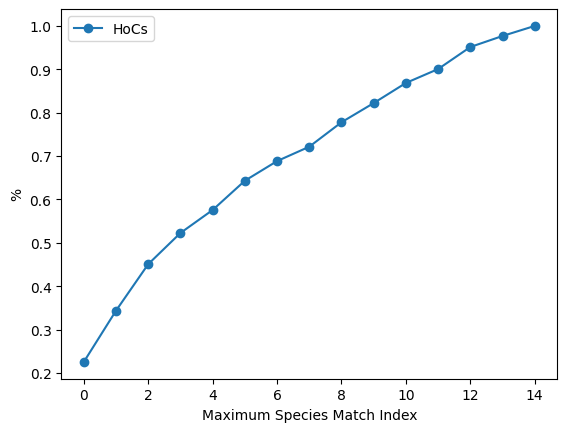

In [115]:
import matplotlib.pyplot as plt

# Plot the lists on the same plot
plt.plot(recognition_rates, label='HoCs', marker='o')

# Set the axis labels and legend
plt.xlabel('Maximum Species Match Index')
plt.ylabel('%')
plt.legend()

# Show the plot
plt.show()